#### Import the needed packages for analysis

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from mord import LogisticIT

import statsmodels.api as sm

from dmba import classificationSummary, gainsChart, liftChart

%matplotlib inline
import matplotlib.pylab as plt

no display found. Using non-interactive Agg backend


### Upload, explore, clean, and preprocess data.
a. Why a logistic regression model may be used in this case? Why may you not apply a multiple linear regression model in this case? Provide brief answers to both questions.

b. Create a flight_df data frame by uploading the original data set into Python. Remove ‘DEST’ and ‘ORIGIN’ variables from the flight_df data frame. Convert ‘CARRIER’ and ‘FL_STATUS’ into binary variables. This portion of part 1 will not be graded.

c. Why does the output variable ‘FL_STATUS’ need to be converted into binary variables for logistic regression? Briefly explain.

#### b. Create a flight_df data frame by uploading the original data set into Python. Remove ‘DEST’ and ‘ORIGIN’ variables from the flight_df data frame. Convert ‘CARRIER’ and ‘FL_STATUS’ into binary variables. This portion of part 1 will not be graded.

In [2]:
# Create a flight_df 
flight_df= pd.read_csv('FlightDelays.csv')
# Display the first 10 records 
flight_df.head()

,SCH_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_NUM,ORIGIN,WEATHER,WK_DAY,MTH_DAY,FL_STATUS
0,1455,OH,1455,JFK,184,5935,BWI,0,4,1,ontime
1,1640,DH,1640,JFK,213,6155,DCA,0,4,1,ontime
2,1245,DH,1245,LGA,229,7208,IAD,0,4,1,ontime
3,1715,DH,1709,LGA,229,7215,IAD,0,4,1,ontime
4,1039,DH,1035,LGA,229,7792,IAD,0,4,1,ontime


In [3]:
# Check if there are any missing data in any column 
flight_df.count()

SCH_TIME     2201
CARRIER      2201
DEP_TIME     2201
DEST         2201
DISTANCE     2201
FL_NUM       2201
ORIGIN       2201
WEATHER      2201
WK_DAY       2201
MTH_DAY      2201
FL_STATUS    2201
dtype: int64

In [4]:
# Remove ‘DEST’ and ‘ORIGIN’ variables from the flight_df data frame
flight_df = flight_df.drop(columns=['DEST', 'ORIGIN'])

# Display the first 10 records after removing "DIST", "ORIGIN"
flight_df.head()


,SCH_TIME,CARRIER,DEP_TIME,DISTANCE,FL_NUM,WEATHER,WK_DAY,MTH_DAY,FL_STATUS
0,1455,OH,1455,184,5935,0,4,1,ontime
1,1640,DH,1640,213,6155,0,4,1,ontime
2,1245,DH,1245,229,7208,0,4,1,ontime
3,1715,DH,1709,229,7215,0,4,1,ontime
4,1039,DH,1035,229,7792,0,4,1,ontime


In [5]:
# Check variables type
flight_df.dtypes




SCH_TIME      int64
CARRIER      object
DEP_TIME      int64
DISTANCE      int64
FL_NUM        int64
WEATHER       int64
WK_DAY        int64
MTH_DAY       int64
FL_STATUS    object
dtype: object

In [6]:
# Convert ‘CARRIER’ and ‘FL_STATUS’ into binary variables.. 
for x in ['CARRIER', 'FL_STATUS']:
    flight_df[x] = flight_df[x].astype('category')
    new_categories = {'ontime': 1, 'delayed' : 0}
flight_df.FL_STATUS.cat.rename_categories(new_categories, inplace=True)

# Display the variable types after conversion
flight_df.dtypes


SCH_TIME        int64
CARRIER      category
DEP_TIME        int64
DISTANCE        int64
FL_NUM          int64
WEATHER         int64
WK_DAY          int64
MTH_DAY         int64
FL_STATUS    category
dtype: object

In [7]:
# Display category levels (attributes) and category type.
print(' ')
print('Category levels and changed variable type:')
print(flight_df.CARRIER.cat.categories)  
print(flight_df.CARRIER.dtype) 
print(flight_df.FL_STATUS.cat.categories)  
print(flight_df.FL_STATUS.dtype)


 
Category levels and changed variable type:
Index(['CO', 'DH', 'DL', 'MQ', 'OH', 'RU', 'UA', 'US'], dtype='object')
category
Int64Index([0, 1], dtype='int64')
category


In [8]:
# Since we have 8 category variables in CARRIER and FL_STATUS
#we will create 7 dummies and drop "CO" and one dummy in FL_STATUS
# Use drop_first=True to drop the first dummy variable for 'None'.
flight_df = pd.get_dummies(flight_df, prefix_sep='_', 
                            drop_first=True, columns=['CARRIER'])
#check the columns after transfering to binary variables 
flight_df.columns

Index(['SCH_TIME', 'DEP_TIME', 'DISTANCE', 'FL_NUM', 'WEATHER', 'WK_DAY',
       'MTH_DAY', 'FL_STATUS', 'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ',
       'CARRIER_OH', 'CARRIER_RU', 'CARRIER_UA', 'CARRIER_US'],
      dtype='object')

### 2- Develop a logistic regression model for the Flight Delays case.
a. Develop in Python the predictor variables (14 variables) and outcome variable (‘FL_STATUS’) and partition the data set (60% for training and 40% for validation partitions). Train a logistic regression model using LogisticRegression() with the training data set and display in Python the model’s parameters (intercept and regression coefficients). Provide these parameters in your report and also present the mathematical equation of the trained logistic regression model.

b. In Python, make predictions and identify probabilities p(0) and p(1) for the validation data set. For the first 20 records in the validation data set, display a table that contains the actual and predicted flight arrival status, and probabilities p(0) and p(1). Present this table in your report, and comment on the predicted vs. actual flight arrival status.

c. Identify and display in Python confusion matrices for the training and validation partitions. Present them in your report and comment on accuracy (misclassification) rate for both partitions and explain if there is a possibility of overfitting.

d. Create and display in Python the Lift chart only for ‘delayed’ flight status. For that, use p(0) for .sort_values() and p(0) in liftChart(). Also use ncols=1 in plt.subplots() for a single plot, and remove ax=axes[1] from liftChart(). Present this Lift chart in your report and briefly explain what the chart demonstrates and what conclusion(s) can be made.

#### a. Develop in Python the predictor variables (14 variables) and outcome variable (‘FL_STATUS’) and partition the data set (60% for training and 40% for validation partitions). Train a logistic regression model using LogisticRegression() with the training data set and display in Python the model’s parameters (intercept and regression coefficients). Provide these parameters in your report and also present the mathematical equation of the trained logistic regression model.

In [9]:
# Create predictors X and outcome y variable.
X = flight_df.drop(columns=['FL_STATUS'])
y = flight_df['FL_STATUS']
# Partition data into training (60% or 0.6) and validation(40% or 0.4)
# of the flight_df data frame.
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                            test_size=0.4, random_state=1)

# Using LogisticRegression() function, fit multiple predictors logistic 
# regression for training partition. Set penalty='l2' for regularization. 
# Regularization is any modification to a learning algorithm that is 
# intended to reduce its generalization error but not its training error.
# Regularization can be used to train models that generalize 
# better on unseen data by preventing the algorithm from overfitting 
# the training data set.
# Parameter C=1e42 and penalty=l2 lead to ordinal logistic regression. 
# solver='liblinear' is used for automated selection of the best parameters
# of the logistis regression; recommended for large-scale classification.
log_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
log_reg.fit(train_X, train_y)
# Show intercept and coefficients of the multiple predictors' logistic model.
print('Parameters of Logistic Regresion Model with Multiple Predictors')
print('Intercept:', np.round(log_reg.intercept_[0], decimals=3))
print('Coefficients for Predictors')
print(pd.DataFrame({'Coeff:': np.round(log_reg.coef_[0], decimals=3)}, 
                    index=X.columns).transpose())


Parameters of Logistic Regresion Model with Multiple Predictors
Intercept: 0.249
Coefficients for Predictors
        SCH_TIME  DEP_TIME  DISTANCE  FL_NUM  WEATHER  WK_DAY  MTH_DAY  \
Coeff:     0.033    -0.033     0.007     0.0   -0.756   0.081   -0.022   

        CARRIER_DH  CARRIER_DL  CARRIER_MQ  CARRIER_OH  CARRIER_RU  \
Coeff:      -0.172       1.049      -1.068       0.702       0.121   

        CARRIER_UA  CARRIER_US  
Coeff:        0.22       0.022  


##### The mathematical equation of the trained logistic regression model
##### logit= 0.051 + 0.033SCH_TIME - 0.034DEP_TIME + 0.009DISTANCE + 0.0FL_NUM - 0.247WEATHER + 0.097WK_DAY - 0.021MTH_DAY + 0.035CARRIER_DH + 0.782CARRIER_DL - 1.054CARRIER_MQ + 0.236CARRIER_OH - 0.05CARRIER_RU + 0.053CARRIER_UA - 0.043CARRIER_US

#### b. In Python, make predictions and identify probabilities p(0) and p(1) for the validation data set. For the first 20 records in the validation data set, display a table that contains the actual and predicted flight arrival status, and probabilities p(0) and p(1). Present this table in your report, and comment on the predicted vs. actual flight arrival status.

In [10]:
# Make predictions for validation set using single
# predictor logistic model. 

# Predict single logistic model's results (0 or 1)
# for validation set.
log_pred = log_reg.predict(valid_X)


# Predict single logistic model's probabilities p(0)
# and p(1) for validation set.
log_prob = np.round(log_reg.predict_proba(valid_X), 
                           decimals=4)

# Create data frame to display simple logistic regression
# resuts for validation set. 
log_result = pd.DataFrame({'Actual': valid_y, 
                        'Classification': log_pred,     
                        'p(0)': [p[0] for p in log_prob],
                        'p(1)': [p[1] for p in log_prob],
                        })
print('Classification for Validation Partition')
print(log_result.head(20))

Classification for Validation Partition
     Actual  Classification    p(0)    p(1)
1276      1               1  0.1436  0.8564
1446      1               1  0.0727  0.9273
335       1               1  0.0770  0.9230
1458      1               1  0.1088  0.8912
2038      1               1  0.0845  0.9155
1314      1               1  0.0718  0.9282
389       1               1  0.0770  0.9230
1639      1               1  0.1154  0.8846
2004      1               1  0.0910  0.9090
403       1               1  0.3032  0.6968
979       1               1  0.0534  0.9466
65        1               1  0.0727  0.9273
2105      1               1  0.1325  0.8675
1162      1               1  0.1320  0.8680
572       1               1  0.3141  0.6859
1026      0               1  0.0600  0.9400
1044      1               1  0.4876  0.5124
1846      0               1  0.4822  0.5178
1005      1               1  0.1347  0.8653
1677      1               1  0.0518  0.9482


#### c. Identify and display in Python confusion matrices for the training and validation partitions. Present them in your report and comment on accuracy (misclassification) rate for both partitions and explain if there is a possibility of overfitting.

In [11]:
# Confusion matrices for the training and validation partitions. 

# Confusion matrix for training partition. 
print('Training Partition')
classificationSummary(train_y, log_reg.predict(train_X))

# Confusion matrix for validation partition. 
print()
print('Validation Partition')
classificationSummary(valid_y, log_reg.predict(valid_X))

Training Partition
Confusion Matrix (Accuracy 0.9038)

       Prediction
Actual    0    1
     0  142  119
     1    8 1051

Validation Partition
Confusion Matrix (Accuracy 0.9069)

       Prediction
Actual   0   1
     0  91  76
     1   6 708


#### d. Create and display in Python the Lift chart only for ‘delayed’ flight status. For that, use p(0) for .sort_values() and p(0) in liftChart(). Also use ncols=1 in plt.subplots() for a single plot, and remove ax=axes[1] from liftChart(). Present this Lift chart in your report and briefly explain what the chart demonstrates and what conclusion(s) can be made.

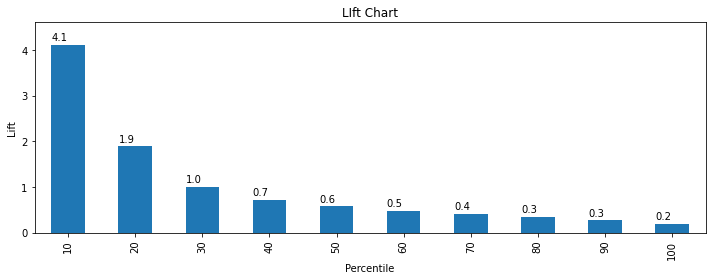

In [15]:
# Develop and display Gains chart and Lift chart. 

# Create a new df data frame from logit_result data frame
# that is sorted by p(1) in descending order.  
df = log_result.sort_values(by=['p(0)'], ascending=False)

# Create a data plot with two plots (ncols=2) 
# back-to-back (nrows=1).
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

# Using gainsChart() function, create Gains chart. 
# In the Gains chart, the 'lift' over the base curve 
# indicates for a given number of cases (on x-axis), 
# the additional responders that you can identify 
# by using the logistic regression model.
# gainsChart(df.Actual, ax=axes[0], color='Blue')

# Using liftChart() function, create decile-wise Lift chart. 
# In this Lift chart, taking the 10% of the records 
# that are ranked by the model as 'most probable 1's' 
# yields 7.8 times as many 1's as would simply selecting 
# 10% of the records at random.
liftChart(df['p(0)'], title='LIft Chart')
 
# Display the charts. 
plt.tight_layout()
plt.show()

### 3. Compare results of logistic regression model vs. classification tree model for the same data set.

a. Present and compare in your report the validation confusion matrix for the logistic regression model in 2c of this case versus the validation confusion matrix using the GridSearchCV() algorithm for the classification tree in the previous case study. Using the accuracy value (misclassification rate), which model would you recommend applying for classification (prediction) of flight arrival status? Briefly explain your answer.